# Training Keyframe Classifier
This notebook guides you through training a machine learning model to detect softball pitching keyframes using the `keyframe_features_dataset.csv` you generated.

In [122]:
import pandas as pd

# 1. Load your original keyframe labels (not the features CSV!)
df_labels = pd.read_csv('keyframe_features_enhanced.csv')

# 2. Expand windows: ±2 for MaxKneeLift, ±1 for everything else
window_map = { 'MaxKneeLift': 0 }
expanded_rows = []
for _, row in df_labels.iterrows():
    w = window_map.get(row['Keyframe_Type'], 1)
    for off in range(-w, w+1):
        fn = row['Frame'] + off
        if fn >= 0:
            expanded_rows.append({
                'Video':         row['Video'],
                'Frame':         fn,
                'Keyframe_Type': row['Keyframe_Type']
            })
df_labels_expanded = pd.DataFrame(expanded_rows)

# 3. Load your extracted features + keyframe type
df_features = pd.read_csv('keyframe_features_enhanced.csv')

# 4. Merge on Video, Frame, and Keyframe_Type
df_merged = pd.merge(
    df_features,
    df_labels_expanded[['Video','Frame','Keyframe_Type']],
    on=['Video','Frame','Keyframe_Type'],
    how='inner'
)

# 5. Inspect results
print("Total original labels:", len(df_labels))
print("Total expanded labels:", len(df_labels_expanded))
print("Merged feature rows:", len(df_merged))
print("\nExpanded label counts by type:\n", 
      df_labels_expanded['Keyframe_Type'].value_counts())

# 6. Quick peek
display(df_merged.head())


Total original labels: 772
Total expanded labels: 2030
Merged feature rows: 1756

Expanded label counts by type:
 Keyframe_Type
LiftOff                  315
FootPlant                285
Release                  270
DragStart                258
ThreeQuarterArmCircle    255
CirclePeak               252
Connection               252
MaxKneeLift              143
Name: count, dtype: int64


,Video,Frame,Keyframe_Type,Humerus_Angle,Femur_Angle,R_Toe_Y_Norm,L_Toe_Y_Norm,L_Heel_Y_Norm,L_Ankle_X_Norm,L_Ankle_Y_Norm,HorizAlign_ShoulderWrist,VertAlign_SternumWrist,Trunk_Lean_Angle,Norm_Stride,Stride_Length,UpperArm_Compression
0,AudryeDumlao.mp4,296,LiftOff,38.919838,115.465615,5.306718,5.155161,4.740319,1.922424,4.766786,0.645086,2.042817,11.207254,1.396133,234.814449,108.734438
1,AudryeDumlao.mp4,296,LiftOff,38.919838,115.465615,5.306718,5.155161,4.740319,1.922424,4.766786,0.645086,2.042817,11.207254,1.396133,234.814449,108.734438
2,AudryeDumlao.mp4,297,LiftOff,37.921827,116.046164,5.343724,5.159400,4.731730,1.963744,4.782877,0.679015,1.906777,13.164298,1.424229,238.050736,109.930414
3,AudryeDumlao.mp4,297,LiftOff,37.921827,116.046164,5.343724,5.159400,4.731730,1.963744,4.782877,0.679015,1.906777,13.164298,1.424229,238.050736,109.930414
4,AudryeDumlao.mp4,297,LiftOff,37.921827,116.046164,5.343724,5.159400,4.731730,1.963744,4.782877,0.679015,1.906777,13.164298,1.424229,238.050736,109.930414


## Data Preprocessing
Split the dataset into features (X) and labels (y), then train-test split.

In [123]:

# 5. Prepare X and y for modeling
feature_cols = [
    "Humerus_Angle",
    "Femur_Angle",
    "R_Toe_Y_Norm",
    "L_Toe_Y_Norm",
    "L_Heel_Y_Norm",
    "L_Ankle_X_Norm",
    "L_Ankle_Y_Norm",
    "HorizAlign_ShoulderWrist",
    "VertAlign_SternumWrist",
    "Trunk_Lean_Angle",
    "Norm_Stride",
    "Stride_Length",
    "UpperArm_Compression"
]

from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
groups = df_merged['Video']  # or 'PitcherID'
train_idx, test_idx = next(gss.split(df_merged, df_merged['Keyframe_Type'], groups))
# build X_train/test and y_train/test from those indices

X = df_merged[feature_cols]
y = df_merged['Keyframe_Type']
# 6. Train/test split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## Model Training
Train a Random Forest classifier.

In [124]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Evaluation
Assess model performance on the test set.

Classification Report:

                       precision    recall  f1-score   support

           CirclePeak       1.00      1.00      1.00        39
           Connection       1.00      1.00      1.00        39
            DragStart       0.82      0.78      0.79        40
            FootPlant       1.00      0.98      0.99        49
              LiftOff       1.00      1.00      1.00        66
          MaxKneeLift       0.71      0.76      0.73        29
              Release       1.00      1.00      1.00        48
ThreeQuarterArmCircle       0.98      1.00      0.99        42

             accuracy                           0.95       352
            macro avg       0.94      0.94      0.94       352
         weighted avg       0.95      0.95      0.95       352



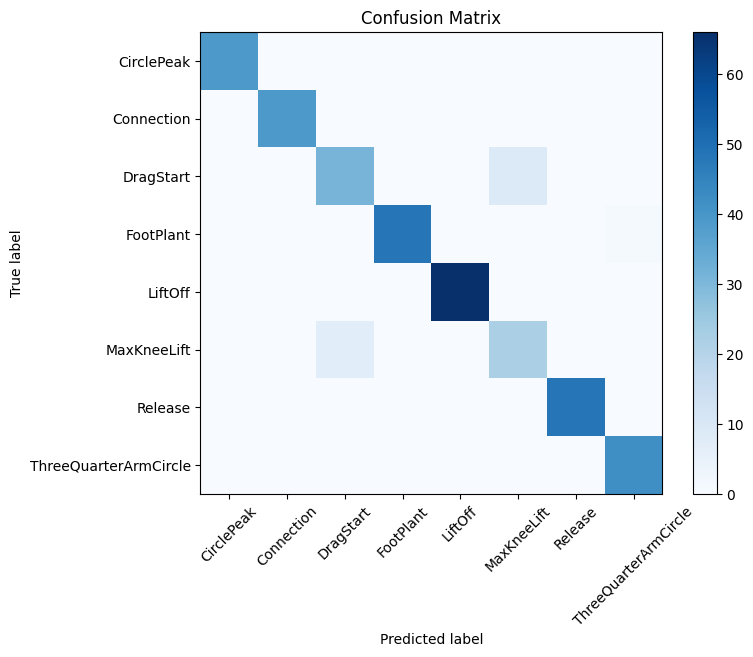

In [125]:

y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(model.classes_)), model.classes_, rotation=45)
plt.yticks(range(len(model.classes_)), model.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Feature Importance
Which features contributed most to the predictions?

Humerus_Angle: 0.192
L_Ankle_X_Norm: 0.144
VertAlign_SternumWrist: 0.122
HorizAlign_ShoulderWrist: 0.095
Trunk_Lean_Angle: 0.087
L_Toe_Y_Norm: 0.072
Femur_Angle: 0.062
L_Heel_Y_Norm: 0.052
L_Ankle_Y_Norm: 0.052
R_Toe_Y_Norm: 0.035
Stride_Length: 0.030
UpperArm_Compression: 0.029
Norm_Stride: 0.027


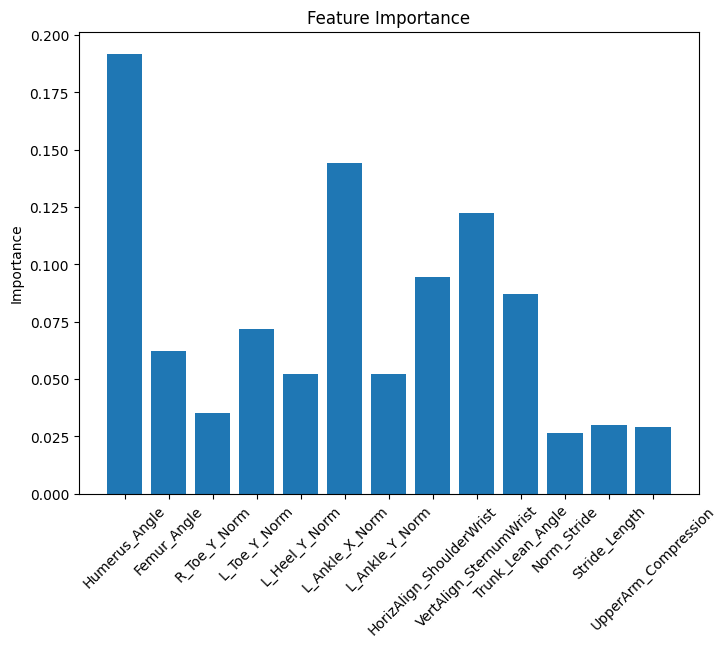

In [126]:
importances = model.feature_importances_
for name, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{name}: {imp:.3f}")
plt.figure(figsize=(8,6))
plt.bar(feature_cols, importances)
plt.xticks(rotation=45)
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

## Next Steps
- Tune hyperparameters or try other models (e.g., XGBoost)
- Use cross-validation for more robust estimates
- Deploy the model to predict keyframes on new videos
- Integrate into your real-time pipeline

In [127]:
import joblib
joblib.dump(model, 'keyframe_classifier.joblib')


['keyframe_classifier.joblib']